In [1]:
import nltk
import json
import os
import pandas as pd
import collections
import copy
import re
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import Counter
from nltk.metrics.agreement import AnnotationTask
from nltk.metrics import masi_distance
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [2]:
def read_json(filename):
    with open('data/'+filename+'.json', 'r', encoding='utf-8') as f: 
        data = json.load(f)
    return data

## DATASETS

In [3]:
# get vectors for each set
union_train_data_vectors = read_json('union_train_vec')
union_dev_data_vectors = read_json('union_dev_vec')
union_test_data_vectors = read_json('union_test_vec')

major_train_data_vectors = read_json('major_train_vec')
major_dev_data_vectors = read_json('major_dev_vec')
major_test_data_vectors = read_json('major_test_vec')

intersec_train_data_vectors = read_json('intersec_train_vec')
intersec_dev_data_vectors = read_json('intersec_dev_vec')
intersec_test_data_vectors = read_json('intersec_test_vec')

In [4]:

# https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

def tekste_labeli_kohta(ann_vectors):
    
    # vektorid df-i
    vecs_data = []
    for ann in ann_vectors['annotations']:
        row = [ann['text']]
        for val in ann['annotation']:
            row.append(val)
        vecs_data.append(row)

    cols = ['Text', "MOOD", "INTERESTS", "ENERGY", "SLEEP", "CONCENTRATION", "CONFIDENCE", "APPETITE", "HARM", "MOVEMENTS", "GUILT"]
    df_vecs = pd.DataFrame(vecs_data, columns=cols)
    #df_vecs['Text'] = df_vecs['Text'].map(lambda text : clean_text(text))

    # loenda tekste labeli kohta
    df_labels = df_vecs.drop(['Text'], axis=1)
    counts = []
    categories = list(df_labels.columns.values)
    for i in categories:
        counts.append((i, df_labels[i].sum()))
    df_stats = pd.DataFrame(counts, columns=['label', 'number_of_texts'])
    
    #display(df_stats)
    return df_stats, df_vecs


def number_of_text_stat_plot(union, major, intersec, status):
    big_df = copy.deepcopy(union)
    big_df = big_df.rename(columns={'number_of_texts':'union '+status+' # of texts'})
    big_df = pd.merge(big_df,major, left_index=True, right_index=True)
    big_df = big_df.rename(columns={'number_of_texts':'majority '+status+' # of texts'})
    big_df = pd.merge(big_df,intersec, left_index=True, right_index=True)
    big_df = big_df.rename(columns={'number_of_texts':'intersection '+status+' # of texts'})
    big_df = big_df.drop(['label_y', 'label'], axis=1)
    big_df = big_df.rename(columns={'label_x':'label'})
    display(big_df)
    return big_df

In [5]:
# get vector dataframes for each set
union_train_data_stats_df, union_train_data_vectors_df = tekste_labeli_kohta(union_train_data_vectors)
union_dev_data_stats_df, union_dev_data_vectors_df = tekste_labeli_kohta(union_dev_data_vectors)
union_test_data_stats_df, union_test_data_vectors_df = tekste_labeli_kohta(union_test_data_vectors)

major_train_data_stats_df, major_train_data_vectors_df = tekste_labeli_kohta(major_train_data_vectors)
major_dev_data_stats_df, major_dev_data_vectors_df = tekste_labeli_kohta(major_dev_data_vectors)
major_test_data_stats_df, major_test_data_vectors_df = tekste_labeli_kohta(major_test_data_vectors)

intersec_train_data_stats_df, intersec_train_data_vectors_df = tekste_labeli_kohta(intersec_train_data_vectors)
intersec_dev_data_stats_df, intersec_dev_data_vectors_df = tekste_labeli_kohta(intersec_dev_data_vectors)
intersec_test_data_stats_df, intersec_test_data_vectors_df = tekste_labeli_kohta(intersec_test_data_vectors)


## General numeric statistics

In [6]:
def make_stat(vectors_dfs, cols):
    start = True
    lens = {"train": 1401, "dev": 200, "test": 401}
    for i, vectors_df in enumerate(vectors_dfs):
        sums={}
        for j, col in enumerate(vectors_df.columns[1:]):
            summa = vectors_df[col].sum()
            sums[col] = summa
        
        posts_with_labels = 0
        posts_with_no_labels = 0
        for index, row in vectors_df.iterrows():
            reasumma = sum(row[1:])
            if reasumma != 0: 
                posts_with_labels += 1
            else:
                posts_with_no_labels += 1
        
        sums["Posts with labels"] = posts_with_labels
        sums["Posts with no labels"] = posts_with_no_labels
        df= pd.DataFrame.from_dict(sums,  orient='index', columns=[cols[i]])
        if start==True:
            final_df = df
            start = False
        else:
            final_df= pd.concat([final_df, df], axis=1)
    return final_df

In [7]:
res1 = make_stat([union_train_data_vectors_df, union_dev_data_vectors_df, union_test_data_vectors_df,
          major_train_data_vectors_df, major_dev_data_vectors_df, major_test_data_vectors_df,
          intersec_train_data_vectors_df, intersec_dev_data_vectors_df, intersec_test_data_vectors_df], 
          ["Union train", "Union dev", "Union test", 
           "Majority train", "Majority dev", "Majority test",
           "Intersection train", "Intersection dev", "Intersection test"])

In [8]:
res1

Union train  Union dev  Union test  Majority train  \
MOOD                         1108        164         321             720   
INTERESTS                     300         39          87              95   
ENERGY                        195         32          58              67   
SLEEP                         138         24          31              66   
CONCENTRATION                 153         24          48              34   
CONFIDENCE                    509         66         120             190   
APPETITE                       67          7          15              37   
HARM                          406         69         120             262   
MOVEMENTS                      83          8          19               8   
GUILT                         467         66         136             162   
Posts with labels            1289        186         365             986   
Posts with no labels          112         14          36             415   

                      Majority dev  Majority test  Intersection train  \
MOOD                           109            210                 303   
INTERESTS                       12             23                  32   
ENERGY                          13             22                  28   
SLEEP                           11             15                  23   
CONCENTRATION                    1              8                   8   
CONFIDENCE                      26             42                  55   
APPETITE                         2              8                  17   
HARM                            42             73                 131   
MOVEMENTS                        3              1                   3   
GUILT                           27             53                  40   
Posts with labels              144            271                 521   
Posts with no labels            56            130                 880   

                      Intersection dev  Intersection test  
MOOD                                48                 82  
INTERESTS                            5                  7  
ENERGY                               5                  5  
SLEEP                                3                  5  
CONCENTRATION                        0                  0  
CONFIDENCE                           1                 10  
APPETITE                             1                  2  
HARM                                17                 40  
MOVEMENTS                            0                  0  
GUILT                                3                 11  
Posts with labels                   71                137  
Posts with no labels               129                264

In [9]:
res2 = make_stat([union_train_data_vectors_df, union_test_data_vectors_df,
          major_train_data_vectors_df, major_test_data_vectors_df,
          intersec_train_data_vectors_df, intersec_test_data_vectors_df], 
          ["Union train",  "Union test", 
           "Majority train",  "Majority test",
           "Intersection train",  "Intersection test"])

In [10]:
res2

Union train  Union test  Majority train  Majority test  \
MOOD                         1108         321             720            210   
INTERESTS                     300          87              95             23   
ENERGY                        195          58              67             22   
SLEEP                         138          31              66             15   
CONCENTRATION                 153          48              34              8   
CONFIDENCE                    509         120             190             42   
APPETITE                       67          15              37              8   
HARM                          406         120             262             73   
MOVEMENTS                      83          19               8              1   
GUILT                         467         136             162             53   
Posts with labels            1289         365             986            271   
Posts with no labels          112          36             415            130   

                      Intersection train  Intersection test  
MOOD                                 303                 82  
INTERESTS                             32                  7  
ENERGY                                28                  5  
SLEEP                                 23                  5  
CONCENTRATION                          8                  0  
CONFIDENCE                            55                 10  
APPETITE                              17                  2  
HARM                                 131                 40  
MOVEMENTS                              3                  0  
GUILT                                 40                 11  
Posts with labels                    521                137  
Posts with no labels                 880                264

In [11]:
res3 = make_stat([union_train_data_vectors_df, union_dev_data_vectors_df, union_test_data_vectors_df,
          major_train_data_vectors_df, major_dev_data_vectors_df, major_test_data_vectors_df,
          intersec_train_data_vectors_df, intersec_dev_data_vectors_df, intersec_test_data_vectors_df], 
          ["Union train", "Union dev", "Union test", 
           "Majority train", "Majority dev", "Majority test",
           "Intersection train", "Intersection dev", "Intersection test"])

In [12]:
res3["Union"] = res3["Union train"] + res3["Union dev"] + res3["Union test"]
res3["Majority"] = res3["Majority train"] + res3["Majority dev"] + res3["Majority test"]
res3["Intersection"] = res3["Intersection train"] + res3["Intersection dev"] + res3["Intersection test"]

In [13]:
res3 = res3.drop(["Union train", "Union dev", "Union test"], axis=1)
res3 = res3.drop(["Majority train", "Majority dev", "Majority test"], axis=1)
res3 = res3.drop(["Intersection train", "Intersection dev", "Intersection test"], axis=1)

In [14]:
res3

Union  Majority  Intersection
MOOD                   1593      1039           433
INTERESTS               426       130            44
ENERGY                  285       102            38
SLEEP                   193        92            31
CONCENTRATION           225        43             8
CONFIDENCE              695       258            66
APPETITE                 89        47            20
HARM                    595       377           188
MOVEMENTS               110        12             3
GUILT                   669       242            54
Posts with labels      1840      1401           729
Posts with no labels    162       601          1273

## How many texts for labels in each set 

In [15]:
train_stat_number_texts = number_of_text_stat_plot(union_train_data_stats_df, 
                                                   major_train_data_stats_df, 
                                                   intersec_train_data_stats_df, 
                                                   'train')

label  union train # of texts  majority train # of texts  \
0           MOOD                    1108                        720   
1      INTERESTS                     300                         95   
2         ENERGY                     195                         67   
3          SLEEP                     138                         66   
4  CONCENTRATION                     153                         34   
5     CONFIDENCE                     509                        190   
6       APPETITE                      67                         37   
7           HARM                     406                        262   
8      MOVEMENTS                      83                          8   
9          GUILT                     467                        162   

   intersection train # of texts  
0                            303  
1                             32  
2                             28  
3                             23  
4                              8  
5                             55  
6                             17  
7                            131  
8                              3  
9                             40

In [16]:
dev_stat_number_texts = number_of_text_stat_plot(union_dev_data_stats_df, 
                                                 major_dev_data_stats_df, 
                                                 intersec_dev_data_stats_df, 
                                                 'dev')

label  union dev # of texts  majority dev # of texts  \
0           MOOD                   164                      109   
1      INTERESTS                    39                       12   
2         ENERGY                    32                       13   
3          SLEEP                    24                       11   
4  CONCENTRATION                    24                        1   
5     CONFIDENCE                    66                       26   
6       APPETITE                     7                        2   
7           HARM                    69                       42   
8      MOVEMENTS                     8                        3   
9          GUILT                    66                       27   

   intersection dev # of texts  
0                           48  
1                            5  
2                            5  
3                            3  
4                            0  
5                            1  
6                            1  
7                           17  
8                            0  
9                            3

In [17]:
test_stat_number_texts = number_of_text_stat_plot(union_test_data_stats_df, 
                                                  major_test_data_stats_df, 
                                                  intersec_test_data_stats_df, 
                                                  'test')

label  union test # of texts  majority test # of texts  \
0           MOOD                    321                       210   
1      INTERESTS                     87                        23   
2         ENERGY                     58                        22   
3          SLEEP                     31                        15   
4  CONCENTRATION                     48                         8   
5     CONFIDENCE                    120                        42   
6       APPETITE                     15                         8   
7           HARM                    120                        73   
8      MOVEMENTS                     19                         1   
9          GUILT                    136                        53   

   intersection test # of texts  
0                            82  
1                             7  
2                             5  
3                             5  
4                             0  
5                            10  
6                             2  
7                            40  
8                             0  
9                            11

In [18]:
def tekste_labeli_kohta_plot(df_stats):
    # palju tekste iga labeli kohta
    df_stats.plot(x='label', y=list(df_stats.columns[1:]), kind='bar', legend=True, grid=True, figsize=(9, 8))
    plt.title("Number of texts per label")
    plt.ylabel('Number of occurrences', fontsize=12)
    plt.xlabel('Label', fontsize=12)
    
    plt.savefig('data/number_of_texts_'+str(df_stats.columns[1].split(" ")[1])+'.png')

## How many texts per label (U+M+I) diagram 

In [19]:
def tekste_labeli_kohta_plot2(df_stats):
    # palju tekste iga labeli kohta
    df_stats.plot(x='label', y=list(df_stats.columns[1:]), kind='bar', legend=True, grid=True, figsize=(15, 15))
    plt.title("Number of texts per label")
    plt.ylabel('Number of occurrences', fontsize=12)
    plt.xlabel('Label', fontsize=12)
    
    plt.savefig('data/number_of_texts_all.png')
    
def tekste_labeli_kohta_plot3(df_stats):
    # palju tekste iga labeli kohta
    df_stats.plot(x='label', y=list(df_stats.columns[1:]), kind='bar', legend=True, grid=True, figsize=(15, 8))
    plt.title("Number of texts per label", fontsize=12)
    plt.ylabel('Number of occurrences', fontsize=12)
    plt.xticks(rotation = 0)
    plt.xlabel('Label', fontsize=12)
    
    plt.savefig('data/number_of_texts_all2.png')

In [20]:
res3 = res3.reset_index()

In [21]:
res3 = res3.rename(columns={'index':'label'})

In [22]:
res3

label  Union  Majority  Intersection
0                   MOOD   1593      1039           433
1              INTERESTS    426       130            44
2                 ENERGY    285       102            38
3                  SLEEP    193        92            31
4          CONCENTRATION    225        43             8
5             CONFIDENCE    695       258            66
6               APPETITE     89        47            20
7                   HARM    595       377           188
8              MOVEMENTS    110        12             3
9                  GUILT    669       242            54
10     Posts with labels   1840      1401           729
11  Posts with no labels    162       601          1273

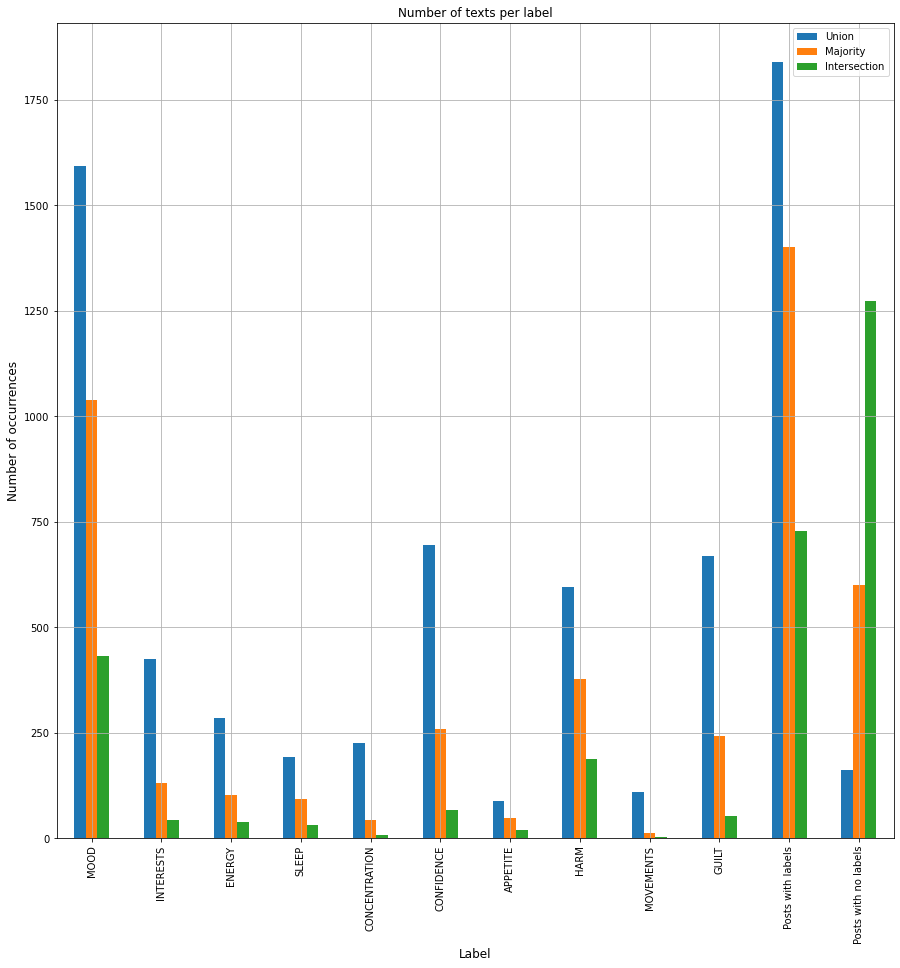

In [23]:
tekste_labeli_kohta_plot2(res3)

In [24]:
res3_2 = res3.drop([10, 11], axis = 0)

In [25]:
res3_2

label  Union  Majority  Intersection
0           MOOD   1593      1039           433
1      INTERESTS    426       130            44
2         ENERGY    285       102            38
3          SLEEP    193        92            31
4  CONCENTRATION    225        43             8
5     CONFIDENCE    695       258            66
6       APPETITE     89        47            20
7           HARM    595       377           188
8      MOVEMENTS    110        12             3
9          GUILT    669       242            54

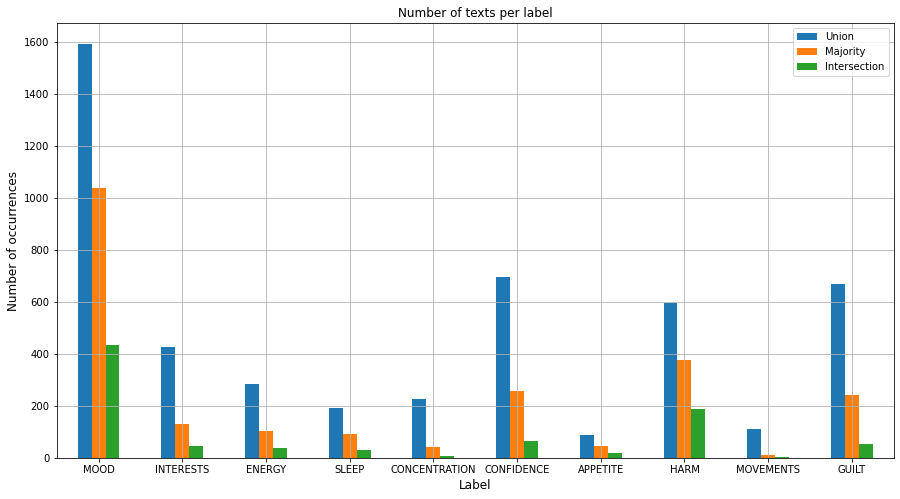

In [26]:
tekste_labeli_kohta_plot3(res3_2)

## How many labels per text (U+M+I)

In [27]:
def get_dict(values):
    values_dict1 = dict((el,0) for el in range(8))
    for val in values.index: 
        values_dict1[val] = values[val]
    return values_dict1

In [28]:
utrain = union_train_data_vectors_df.iloc[:,1:].sum(axis=1).value_counts()
mtrain = major_train_data_vectors_df.iloc[:,1:].sum(axis=1).value_counts()
itrain = intersec_train_data_vectors_df.iloc[:,1:].sum(axis=1).value_counts()

udev = union_dev_data_vectors_df.iloc[:,1:].sum(axis=1).value_counts()
mdev = major_dev_data_vectors_df.iloc[:,1:].sum(axis=1).value_counts()
idev = intersec_dev_data_vectors_df.iloc[:,1:].sum(axis=1).value_counts()

utest = union_test_data_vectors_df.iloc[:,1:].sum(axis=1).value_counts()
mtest = major_test_data_vectors_df.iloc[:,1:].sum(axis=1).value_counts()
itest = intersec_test_data_vectors_df.iloc[:,1:].sum(axis=1).value_counts()

df1 = pd.DataFrame.from_dict(get_dict(utrain), orient='index', columns = ['ocurrences in union train'])
df2 = pd.DataFrame.from_dict(get_dict(mtrain), orient='index', columns = ['ocurrences in major train'])
df3 = pd.DataFrame.from_dict(get_dict(itrain), orient='index', columns = ['ocurrences in intersec train'])
df4 = pd.DataFrame.from_dict(get_dict(udev), orient='index', columns = ['ocurrences in union dev'])
df5 = pd.DataFrame.from_dict(get_dict(mdev), orient='index', columns = ['ocurrences in major dev'])
df6 = pd.DataFrame.from_dict(get_dict(idev), orient='index', columns = ['ocurrences in intersec dev'])
df7 = pd.DataFrame.from_dict(get_dict(utest), orient='index', columns = ['ocurrences in union test'])
df8 = pd.DataFrame.from_dict(get_dict(mtest), orient='index', columns = ['ocurrences in major test'])
df9 = pd.DataFrame.from_dict(get_dict(itest), orient='index', columns = ['ocurrences in intersec test'])

big_df = pd.merge(df1,df2, left_index=True, right_index=True)
big_df = pd.merge(big_df,df3, left_index=True, right_index=True)
big_df = pd.merge(big_df,df4, left_index=True, right_index=True)
big_df = pd.merge(big_df,df5, left_index=True, right_index=True)
big_df = pd.merge(big_df,df6, left_index=True, right_index=True)
big_df = pd.merge(big_df,df7, left_index=True, right_index=True)
big_df = pd.merge(big_df,df8, left_index=True, right_index=True)
big_df = pd.merge(big_df,df9, left_index=True, right_index=True)

In [29]:
big_df["ocurrences in Union"] = big_df['ocurrences in union train']+big_df['ocurrences in union dev']+big_df['ocurrences in union test']
big_df["ocurrences in Majority"] = big_df['ocurrences in major train']+big_df['ocurrences in major dev']+big_df['ocurrences in major test']
big_df["ocurrences in Intersection"] = big_df['ocurrences in intersec train']+big_df['ocurrences in intersec dev']+big_df['ocurrences in intersec test']

big_df = big_df.drop(['ocurrences in union train', 'ocurrences in union dev', 'ocurrences in union test'], axis=1)
big_df = big_df.drop(['ocurrences in major train', 'ocurrences in major dev', 'ocurrences in major test'], axis=1)
big_df = big_df.drop(['ocurrences in intersec train', 'ocurrences in intersec dev', 'ocurrences in intersec test'], axis=1)

In [30]:
big_df = big_df.rename(columns={'ocurrences in Union':'Union'})
big_df = big_df.rename(columns={'ocurrences in Majority':'Majority'})
big_df = big_df.rename(columns={'ocurrences in Intersection':'Intersection'})

In [31]:
big_df

Union  Majority  Intersection
0    162       601          1273
1    408       718           590
2    492       479           125
3    492       159            11
4    287        37             3
5    116         7             0
6     35         1             0
7      6         0             0

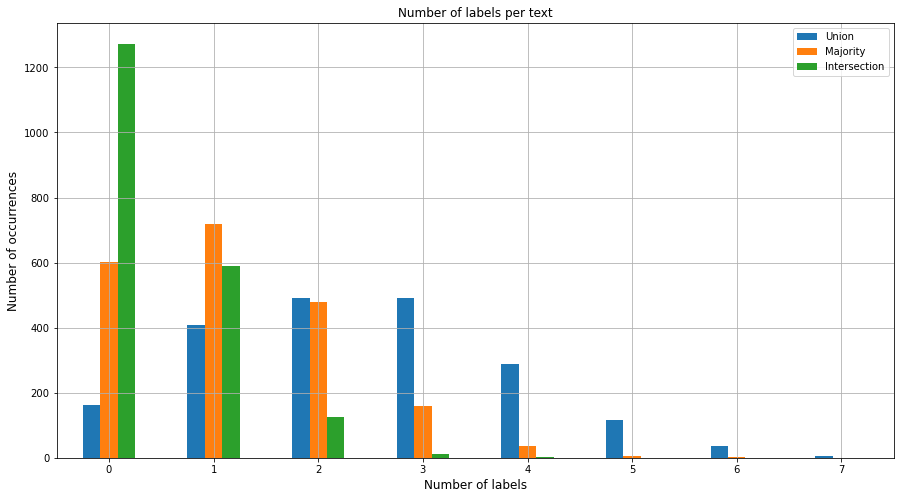

In [32]:
big_df.plot(y=list(big_df.columns), kind='bar', legend=True, grid=True, figsize=(15, 8))

plt.title("Number of labels per text", fontsize=12)
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Number of labels', fontsize=12)
plt.xticks(rotation = 0)
plt.savefig('data/number_of_labels_all.png')

## Text per label for each set

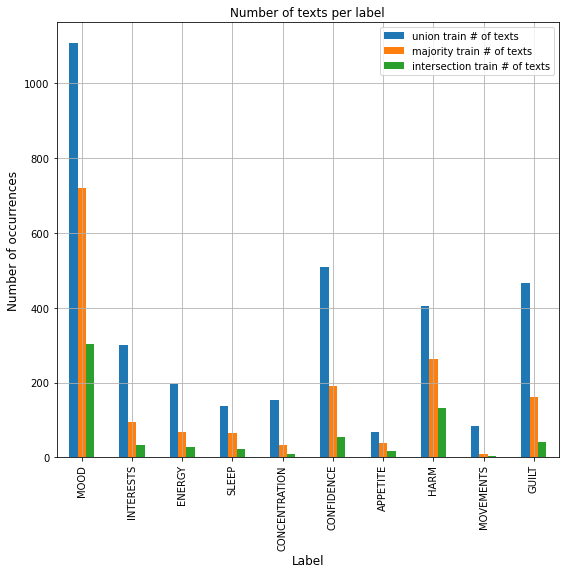

In [33]:
tekste_labeli_kohta_plot(train_stat_number_texts)

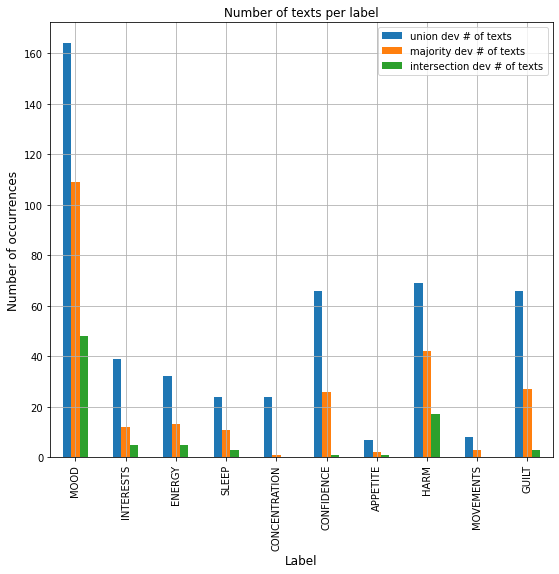

In [34]:
tekste_labeli_kohta_plot(dev_stat_number_texts)

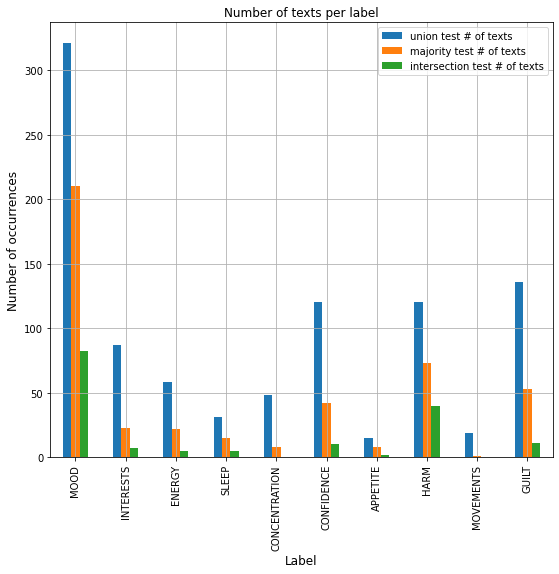

In [35]:
tekste_labeli_kohta_plot(test_stat_number_texts)

## NUMBER OF LABELS FOR POSTS

In [36]:
def palju_labeleid_tekstidel_plot(df_vecs1, df_vecs2, df_vecs3, status):
    # kui palju oli tekste 0, 1, 2, ... labeliga

    plt.figure(figsize=(10,8))
    rowsums1 = df_vecs1.iloc[:,2:].sum(axis=1)
    x1=rowsums1.value_counts()
    rowsums2 = df_vecs2.iloc[:,2:].sum(axis=1)
    x2=rowsums2.value_counts()
    rowsums3 = df_vecs3.iloc[:,2:].sum(axis=1)
    x3=rowsums3.value_counts()

    values_dict1 = dict((el,0) for el in range(8))
    for val in x1.index:
        values_dict1[val] = x1[val]
    values_dict2 = dict((el,0) for el in range(8))
    for val in x2.index:
        values_dict2[val] = x2[val]
    values_dict3 = dict((el,0) for el in range(8))
    for val in x3.index:
        values_dict3[val] = x3[val]

    df1 = pd.DataFrame.from_dict(values_dict1, orient='index', columns = ['ocurrences in union '+status])
    df2 = pd.DataFrame.from_dict(values_dict2, orient='index', columns = ['ocurrences in majority '+status])
    df3 = pd.DataFrame.from_dict(values_dict3, orient='index', columns = ['ocurrences in intersection '+status])

    big_df = pd.merge(df1,df2, left_index=True, right_index=True)
    big_df = pd.merge(big_df,df3, left_index=True, right_index=True)

    big_df.plot(y=list(big_df.columns), kind='bar', legend=True, grid=True, figsize=(8, 8))

    plt.title("Number of labels per text")
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('# of labels', fontsize=12)
    
    #print(big_df.columns[0].split(" ")[3])
    plt.savefig('data/number_of_labels_'+str(big_df.columns[0].split(" ")[3])+'.png')


def get_avg(vecs, pikkus):
    rowsums = vecs.iloc[:,2:].sum(axis=1)
    x=rowsums.value_counts()
    summa = 0
    for val in x.index:
        summa += val*x[val]
    avg_labels = round(summa/pikkus, 2)
    return avg_labels


def num_labels_avg(df_vecs1, df_vecs2, df_vecs3, df_vecs4, df_vecs5, df_vecs6, df_vecs7, df_vecs8, df_vecs9):
    len_train = 1401
    len_dev = 200
    len_test = 401
    d = {"Union_train": get_avg(df_vecs1, len_train),
         "Majority_train": get_avg(df_vecs2, len_train),
         "Intersection_train": get_avg(df_vecs3, len_train),
         "Union_dev": get_avg(df_vecs4, len_dev),
         "Majority_dev": get_avg(df_vecs5, len_dev),
         "Intersection_dev": get_avg(df_vecs6, len_dev),
         "Union_test": get_avg(df_vecs7, len_test),
         "Majority_test": get_avg(df_vecs8, len_test),
         "Intersection_test": get_avg(df_vecs9, len_test)}
    df = pd.DataFrame.from_dict(d, orient='index', columns = ['avg # of labels for text'])
    display(df)

In [37]:
num_labels_avg(union_train_data_vectors_df, major_train_data_vectors_df, intersec_train_data_vectors_df, 
               union_dev_data_vectors_df, major_dev_data_vectors_df, intersec_dev_data_vectors_df, 
               union_test_data_vectors_df, major_test_data_vectors_df, intersec_test_data_vectors_df)

avg # of labels for text
Union_train                             1.65
Majority_train                          0.66
Intersection_train                      0.24
Union_dev                               1.68
Majority_dev                            0.68
Intersection_dev                        0.18
Union_test                              1.58
Majority_test                           0.61
Intersection_test                       0.20

<Figure size 720x576 with 0 Axes>

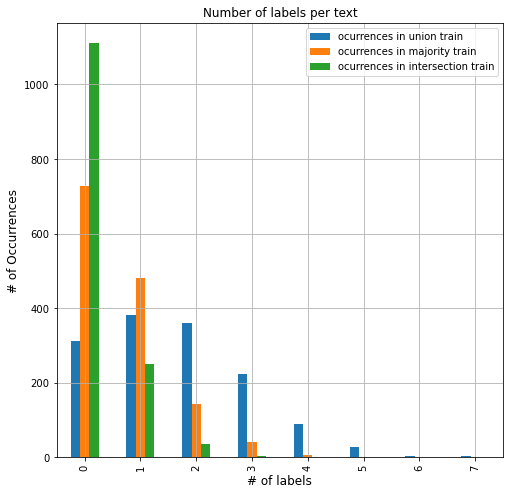

In [38]:
palju_labeleid_tekstidel_plot(union_train_data_vectors_df, major_train_data_vectors_df, intersec_train_data_vectors_df, 'train')

<Figure size 720x576 with 0 Axes>

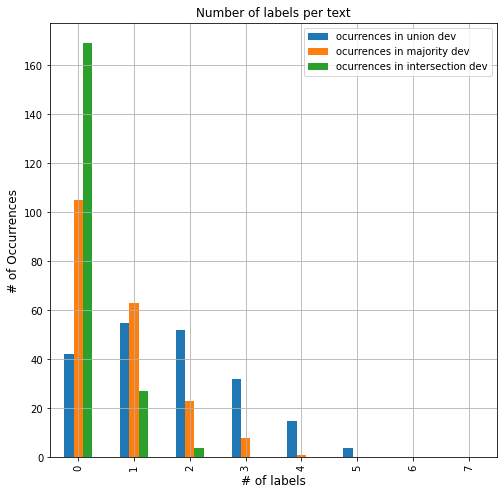

In [39]:
palju_labeleid_tekstidel_plot(union_dev_data_vectors_df, major_dev_data_vectors_df, intersec_dev_data_vectors_df, 'dev')

<Figure size 720x576 with 0 Axes>

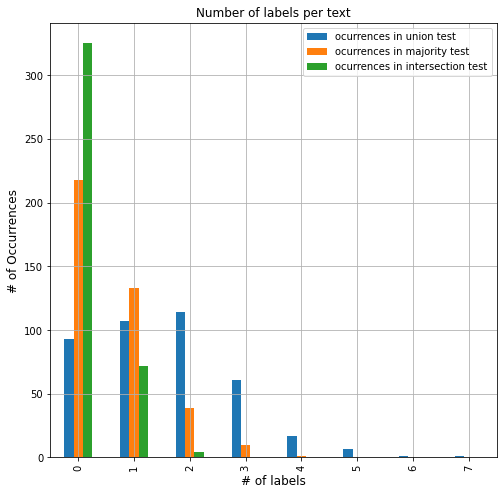

In [40]:
palju_labeleid_tekstidel_plot(union_test_data_vectors_df, major_test_data_vectors_df, intersec_test_data_vectors_df, 'test')

## Annotation agreement

In [41]:
with open('data/train_data.json', 'r', encoding='utf-8') as f: 
    train_data = json.load(f)
    
with open('data/dev_data.json', 'r', encoding='utf-8') as f: 
    dev_data = json.load(f)
    
with open('data/test_data.json', 'r', encoding='utf-8') as f: 
    test_data = json.load(f)

In [49]:
# metrikud

# Krippendorff's Alpha using MASI distance (kodutöö alusel)

def krippendorffalpha(data):
    tuples = []

    annotations = data['annotations']

    for ann in annotations:
        ann1 = frozenset(ann['annotation1']) if len(ann['annotation1']) >= 1 else frozenset('None')
        ann2 = frozenset(ann['annotation2']) if len(ann['annotation2']) >= 1 else frozenset('None')
        ann3 = frozenset(ann['annotation3']) if len(ann['annotation3']) >= 1 else frozenset('None')

        tuples.append(('1',ann['id'], ann1))
        tuples.append(('2',ann['id'], ann2))
        tuples.append(('3',ann['id'], ann3))

    task = AnnotationTask(data=tuples, distance=masi_distance)
    alpha = task.alpha()
    print(alpha)
    return alpha
    
    
# Fleiss' Kappa
def fleiss_kappa(data):
    annotations = data['annotations']
    labels = ["MOOD", "INTERESTS", "ENERGY", "SLEEP", "CONCENTRATION", "CONFIDENCE", "APPETITE", "HARM", "MOVEMENTS", "GUILT"]
    kappas =  {'MOOD':0, 'INTERESTS':0, 'ENERGY':0, 'SLEEP':0, 'CONCENTRATION':0, 'CONFIDENCE':0, 'APPETITE':0, 'HARM':0, 'MOVEMENTS':0, 'GUILT':0}
    tuples = []
    for label in labels:
        # iterate over the whole dataset and fill in the tuples
        for ann in annotations:
            tuple1 = ('1', ann['id'], frozenset('1')) if label in ann['annotation1'] else ('1', ann['id'], frozenset('0'))
            tuple2 = ('2', ann['id'], frozenset('1')) if label in ann['annotation2'] else ('2', ann['id'], frozenset('0'))
            tuple3 = ('3', ann['id'], frozenset('1')) if label in ann['annotation3'] else ('3', ann['id'], frozenset('0'))

            tuples.append(tuple1)
            tuples.append(tuple2)
            tuples.append(tuple3)

        # initialize AnnotationTask
        task = AnnotationTask(data=tuples, distance=masi_distance)

        # get the Fleiss' Kappa value
        kappa = task.multi_kappa()
        kappas[label] = kappa
        tuples = []

    print(kappas)
    return kappas

In [51]:
with open('annotations.json', 'r', encoding='utf-8') as f: 
    all_data = json.load(f)

In [52]:
print("TRAIN")
# krippendorff alpha
train_alpha = krippendorffalpha(train_data)
# fleiss' kappa
train_kappa = fleiss_kappa(train_data)

print("DEV")
# krippendorff alpha
dev_alpha = krippendorffalpha(dev_data)
# fleiss' kappa
dev_kappa = fleiss_kappa(dev_data)

print("TEST")
# krippendorff alpha
test_alpha = krippendorffalpha(test_data)
# fleiss' kappa
test_kappa = fleiss_kappa(test_data)

print("ALL")
# krippendorff alpha
test_alpha = krippendorffalpha(all_data)
# fleiss' kappa
test_kappa = fleiss_kappa(all_data)

TRAIN
0.23022243795708786
{'MOOD': 0.2358759980893597, 'INTERESTS': 0.30191594388822324, 'ENERGY': 0.38190142314815073, 'SLEEP': 0.4646826438427624, 'CONCENTRATION': 0.22031341754078834, 'CONFIDENCE': 0.2694417101882406, 'APPETITE': 0.5745701670745857, 'HARM': 0.5754269423576851, 'MOVEMENTS': 0.13015133876600873, 'GUILT': 0.24179183549830763}
DEV
0.19748217144230584
{'MOOD': 0.23396949085385987, 'INTERESTS': 0.3305109776508815, 'ENERGY': 0.4128520169620534, 'SLEEP': 0.41085706270164113, 'CONCENTRATION': -0.0014604631754626665, 'CONFIDENCE': 0.1730805928376061, 'APPETITE': 0.38993390950686163, 'HARM': 0.48466379267627974, 'MOVEMENTS': 0.2592592592592605, 'GUILT': 0.2191857222532068}
TEST
0.2341431557661492
{'MOOD': 0.20542709568302947, 'INTERESTS': 0.24344975591349677, 'ENERGY': 0.32928330230062836, 'SLEEP': 0.46781685467816947, 'CONCENTRATION': 0.10461924919756249, 'CONFIDENCE': 0.2562554798678089, 'APPETITE': 0.4689823775084065, 'HARM': 0.5742252306058797, 'MOVEMENTS': 0.0344696489671

## PIPELINES

In [44]:
# pipeline tests

# pipeline, Naive bayes OneVsResrClassifieri sees
def NB_pipe(train, test, X_train, X_test):
    labels = ["MOOD", "INTERESTS", "ENERGY", "SLEEP", "CONCENTRATION", "CONFIDENCE", "APPETITE", "HARM", "MOVEMENTS", "GUILT"]
    
    # pipeline combining a text feature extractor with multi lable classifier
    NB_pipe = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english')),
                    ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),
                    ])
    
    results = []
    for label in labels:
        # train the model
        NB_pipe.fit(X_train, train[label])
        # test accuracy
        prediction = NB_pipe.predict(X_test)
        acc = accuracy_score(test[label], prediction)
        results.append([label, acc])
    return results
        
# linearSVC: Linear Support Vector Classification.
def SVC_pipe(train, test, X_train, X_test):
    labels = ["MOOD", "INTERESTS", "ENERGY", "SLEEP", "CONCENTRATION", "CONFIDENCE", "APPETITE", "HARM", "MOVEMENTS", "GUILT"]
    SVC_pipe = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
                ])
    results = []
    for label in labels:
        SVC_pipe.fit(X_train, train[label])
        prediction = SVC_pipe.predict(X_test)
        acc = accuracy_score(test[label], prediction)
        results.append([label, acc])
    return results
        
# Logistic regression
def LR_pipe(train, test, X_train, X_test):
    labels = ["MOOD", "INTERESTS", "ENERGY", "SLEEP", "CONCENTRATION", "CONFIDENCE", "APPETITE", "HARM", "MOVEMENTS", "GUILT"]
    LogReg_pipe = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
                ])
    results = []
    for label in labels:
        LogReg_pipe.fit(X_train, train[label])
        prediction = LogReg_pipe.predict(X_test)
        acc = accuracy_score(test[label], prediction)
        results.append([label, acc])
    return results
        

        
def pipes_acc_comparison(train, test, X_train, X_test):
    labels = ["MOOD", "INTERESTS", "ENERGY", "SLEEP", "CONCENTRATION", "CONFIDENCE", "APPETITE", "HARM", "MOVEMENTS", "GUILT"]
    
    nb_res = NB_pipe(train, test, X_train, X_test)
    svc_res = SVC_pipe(train, test, X_train, X_test)
    lr_res = LR_pipe(train, test, X_train, X_test)
    
    acc_data = []
    for i in range(len(labels)):
        acc_data.append([nb_res[i][0], nb_res[i][1], svc_res[i][1], lr_res[i][1]])
    
    acc_df = pd.DataFrame(acc_data, columns=['labels', 'NB_acc', 'SVC_acc', 'LR_acc'])
    display(acc_df)

In [45]:
X_train = union_train_data_vectors_df.Text
X_test = union_dev_data_vectors_df.Text

# union pipes
pipes_acc_comparison(union_train_data_vectors_df, union_dev_data_vectors_df, X_train, X_test)

labels  NB_acc  SVC_acc  LR_acc
0           MOOD   0.820    0.790   0.820
1      INTERESTS   0.805    0.815   0.810
2         ENERGY   0.840    0.875   0.845
3          SLEEP   0.880    0.900   0.880
4  CONCENTRATION   0.880    0.885   0.880
5     CONFIDENCE   0.670    0.665   0.670
6       APPETITE   0.965    0.975   0.965
7           HARM   0.655    0.745   0.700
8      MOVEMENTS   0.960    0.960   0.960
9          GUILT   0.670    0.630   0.680

In [46]:
X_train = major_train_data_vectors_df.Text
X_test = major_dev_data_vectors_df.Text

# intersection pipes
pipes_acc_comparison(major_train_data_vectors_df, major_dev_data_vectors_df, X_train, X_test)

labels  NB_acc  SVC_acc  LR_acc
0           MOOD   0.610    0.635   0.695
1      INTERESTS   0.940    0.935   0.940
2         ENERGY   0.935    0.940   0.935
3          SLEEP   0.945    0.950   0.945
4  CONCENTRATION   0.995    0.995   0.995
5     CONFIDENCE   0.870    0.870   0.870
6       APPETITE   0.990    0.980   0.990
7           HARM   0.790    0.800   0.790
8      MOVEMENTS   0.985    0.985   0.985
9          GUILT   0.865    0.850   0.865

In [48]:
#X_train = intersec_train_data_vectors_df.Text
#X_test = intersec_dev_data_vectors_df.Text

# intersection pipes
#pipes_acc_comparison(intersec_train_data_vectors_df, intersec_dev_data_vectors_df, X_train, X_test)